**1.0 Importing Required Library**

In [0]:
import os
import numpy as np
import pandas as pd
import sqlite3

from collections import Counter
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from matplotlib import pyplot as plt
from prettytable import PrettyTable

Using TensorFlow backend.


**2.0 Importing DataSet**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
if os.path.isfile("/content/drive/My Drive/Colab Notebooks/final.sqlite"):
    conn=sqlite3.connect("/content/drive/My Drive/Colab Notebooks/final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [0]:
Data=Data.sample(100000)

In [0]:
Data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
355679,466759,504717,B007I7YZJK,A27ULPK1RGCNU6,Picky CO Mom,2,3,0,1333929600,not a fan,I was trying all of the honey tea flavors that...,tri honey tea flavor came fan one two tri actu...
157277,216333,234436,B001BDI0QQ,AN5T6MAD6FC5I,Legal&Sane,0,0,1,1331769600,Kitties love it and a lot less expensive than ...,"One of the kitties has a very sensitive tummy,...",one kitti sensit tummi spend quit bit money me...


In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(Data['CleanedText'],Data['Score'],test_size=0.33)

In [0]:
print("Train Data Shape ")
print(X_train.shape,Y_train.shape)

print("\nTest Data Shape ")
print(X_test.shape,Y_test.shape)

Train Data Shape 
(67000,) (67000,)

Test Data Shape 
(33000,) (33000,)


**3.0 Text Preprocessing**
    
     These Function basically prepares the data to be loaded and processed similar to IMDB data in datasets.
    1. A Vocabulary is created with all the words and it's Frequencies.
    2. Top 'num_words' are selected and another dictionary 'word_idx' is created to store the ranks of the corresponding words.
    3. Finally, train and test data (x's & y's) are returned to the caller.

In [0]:
vocab = Counter()
word_idx = dict()


def load_data(X_train , X_test, num_words=5000):
    cnt=1
    max_sent_len = 0    
   
    for review in X_train:
        if len(review.split()) > max_sent_len:
            max_sent_len = len(review.split())
        for word in review.split():
            vocab[word] += 1

    for x,y in vocab.most_common(num_words):
        word_idx[x] = cnt
        cnt += 1
    
    def transform_data(data):
        data_idx = []
        for review in data:
            temp_idx = []
            for word in review.split():
                if 0 < word_idx.get(word, 0) <= num_words:
                    temp_idx.append(word_idx[word])
            data_idx.append(temp_idx)

        return data_idx
        
    x_train = transform_data(X_train)
    x_test = transform_data(X_test)
    
    return x_train , x_test

In [0]:
%%time
num_words = 5000
x_train ,x_test = load_data(X_train , X_test,num_words=num_words)

CPU times: user 3.03 s, sys: 16.2 ms, total: 3.05 s
Wall time: 3.07 s


In [0]:
    print(f'Most Common Words :-\n{vocab.most_common(10)}')
    print(f'\nWord Ranks :-\n{word_idx}')

Most Common Words :-
[('like', 31265), ('tast', 29754), ('flavor', 23963), ('good', 23443), ('use', 21977), ('product', 21751), ('one', 21464), ('love', 21150), ('great', 20291), ('tri', 19375)]

Word Ranks :-
{'like': 1, 'tast': 2, 'flavor': 3, 'good': 4, 'use': 5, 'product': 6, 'one': 7, 'love': 8, 'great': 9, 'tri': 10, 'tea': 11, 'coffe': 12, 'make': 13, 'get': 14, 'food': 15, 'would': 16, 'buy': 17, 'time': 18, 'realli': 19, 'eat': 20, 'amazon': 21, 'order': 22, 'dont': 23, 'much': 24, 'price': 25, 'also': 26, 'find': 27, 'littl': 28, 'bag': 29, 'dog': 30, 'even': 31, 'best': 32, 'drink': 33, 'well': 34, 'store': 35, 'ive': 36, 'better': 37, 'chocol': 38, 'mix': 39, 'box': 40, 'day': 41, 'water': 42, 'recommend': 43, 'year': 44, 'look': 45, 'sugar': 46, 'sweet': 47, 'first': 48, 'want': 49, 'give': 50, 'packag': 51, 'cup': 52, 'brand': 53, 'purchas': 54, 'found': 55, 'think': 56, 'work': 57, 'high': 58, 'made': 59, 'way': 60, 'bought': 61, 'treat': 62, 'enjoy': 63, 'say': 64, 'nee

In [0]:
max_review_length = 824
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(x_train.shape, x_test.shape)

(67000, 824) (33000, 824)


**4.0 Plot Function**

In [0]:
def plot_loss(x, vy, ty, xlabel='Epoch', ylabel='Binary Crossentropy Loss'):
    _, = plt.plot(x, vy, 'b', label="Validation Loss")
    _, = plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.legend()
    plt.grid()
    plt.show()

In [0]:
pt = PrettyTable()
pt.field_names = ['RNN Architecture', 'Mean Train Accuracy', 'Mean Validation Accuracy', 'Test Accuracy']

**5.0 Model**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 824, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1720      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 161,763
Trainable params: 161,763
Non-trainable params: 0
_________________________________________________________________
None
Train on 46900 samples, validate on 20100 samples
Epoch 1/10
46900/46900 [==============================] - 424s 9ms/step - loss: 0.6153 - acc: 0.7331 - val_loss: 0.4339 - val_acc: 0.8407
Epoch 2/10
46900/46900 [==============================] - 423s 9ms/step - loss: 0.4282 - acc: 0.8585 - val_loss: 0.4062 - val_acc: 0.8735
Epoch 3/10
46900/46900 [==============================] - 422s 9ms/st

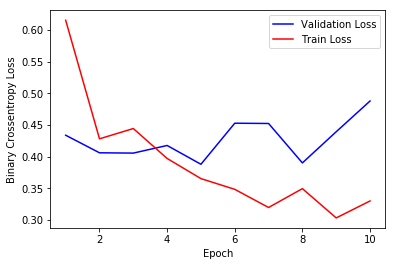

CPU times: user 2h 3min 4s, sys: 5min 51s, total: 2h 8min 56s
Wall time: 1h 11min 16s


In [0]:
%%time
# create the model
def get_LSTM(embedding_vector_length = 32):
    model = Sequential()
    model.add(Embedding(num_words+1, embedding_vector_length, input_length=max_review_length))

    model.add(LSTM(10, dropout=0.25, recurrent_dropout=0.25))

    model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model


model = get_LSTM()
epochs = 10
history = model.fit(x_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.3)

# Final evaluation of the model
score = model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1, epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_loss(x, vy, ty)

pt.add_row(['1-layered LSTM+Dropouts', sum(history.history['acc'])/len(history.history['acc']), \
            sum(history.history['val_acc'])/len(history.history['val_acc']), score[1]]) 

**5.1  2-Layered LSTM Architecture**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 824, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 824, 10)           1720      
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 161,859
Trainable params: 161,859
Non-trainable params: 0
_________________________________________________________________
None
Train on 170795 samples, validate on 73199 samples
Epoch 1/5
170795/170795 [==============================] - 2965s 17ms/step - loss: 0.3636 - acc: 0.8663 - val_loss: 0.3011 - val_acc: 0.8963
Epoch 2/5
170795/170795 [==============================] - 3009s 18ms/s

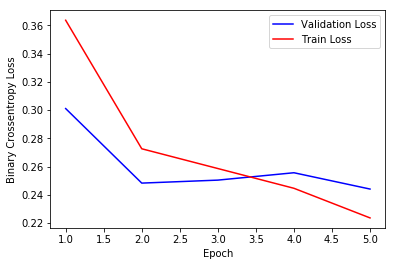

+-------------------------+---------------------+--------------------------+--------------------+
|     RNN Architecture    | Mean Train Accuracy | Mean Validation Accuracy |   Test Accuracy    |
+-------------------------+---------------------+--------------------------+--------------------+
| 2-layered LSTM+Dropouts |  0.8862976082448479 |    0.898837415818857     | 0.9099162069291064 |
| 2-layered LSTM+Dropouts |   0.90428174126961  |    0.9097091490376276    | 0.917912745368242  |
+-------------------------+---------------------+--------------------------+--------------------+
CPU times: user 7h 40min 7s, sys: 25min 23s, total: 8h 5min 31s
Wall time: 4h 17min 44s


In [0]:
%%time
# create the model
def get_LSTM(embedding_vector_length = 32):
    model = Sequential()
    model.add(Embedding(num_words+1, embedding_vector_length, input_length=max_review_length))

    model.add(LSTM(10, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(2, dropout=0.25, recurrent_dropout=0.25))

    model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model


model = get_LSTM()
epochs = 5
history = model.fit(x_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.3)

# Final evaluation of the model
score = model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1, epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_loss(x, vy, ty)

pt.add_row(['2-layered LSTM+Dropouts', sum(history.history['acc'])/len(history.history['acc']), \
            sum(history.history['val_acc'])/len(history.history['val_acc']), score[1]])

print(pt)

**6.0 Conclusion**

1. I have used 243K data point for multi layered LSTM but for singled layered 100k data point is used.

2. Single Layered Architecture is working well .

3. Multi Layered Architecture is also working well .